# Credit card

## Reference 

In [32]:
# https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

## Import library

In [59]:
import numpy as np
import pandas as pd
import re
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering, BisectingKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform


## Import dataset

In [34]:
path = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/credit_card_customers.csv'
credit_card = pd.read_csv(path)
credit_card.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Clean dataset 

In [35]:
# credit_card.info()
# remove the cust_id in dataframe
credit_card1 = credit_card.copy()
credit_card1 = credit_card1.dropna()
credit_card1 = credit_card1.drop(columns = 'CUST_ID')
credit_card1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8636 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8636 non-null   float64
 1   BALANCE_FREQUENCY                 8636 non-null   float64
 2   PURCHASES                         8636 non-null   float64
 3   ONEOFF_PURCHASES                  8636 non-null   float64
 4   INSTALLMENTS_PURCHASES            8636 non-null   float64
 5   CASH_ADVANCE                      8636 non-null   float64
 6   PURCHASES_FREQUENCY               8636 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8636 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8636 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8636 non-null   float64
 10  CASH_ADVANCE_TRX                  8636 non-null   int64  
 11  PURCHASES_TRX                     8636 non-null   int64  
 12  CREDIT

In [36]:
credit_card1.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Visualize the data

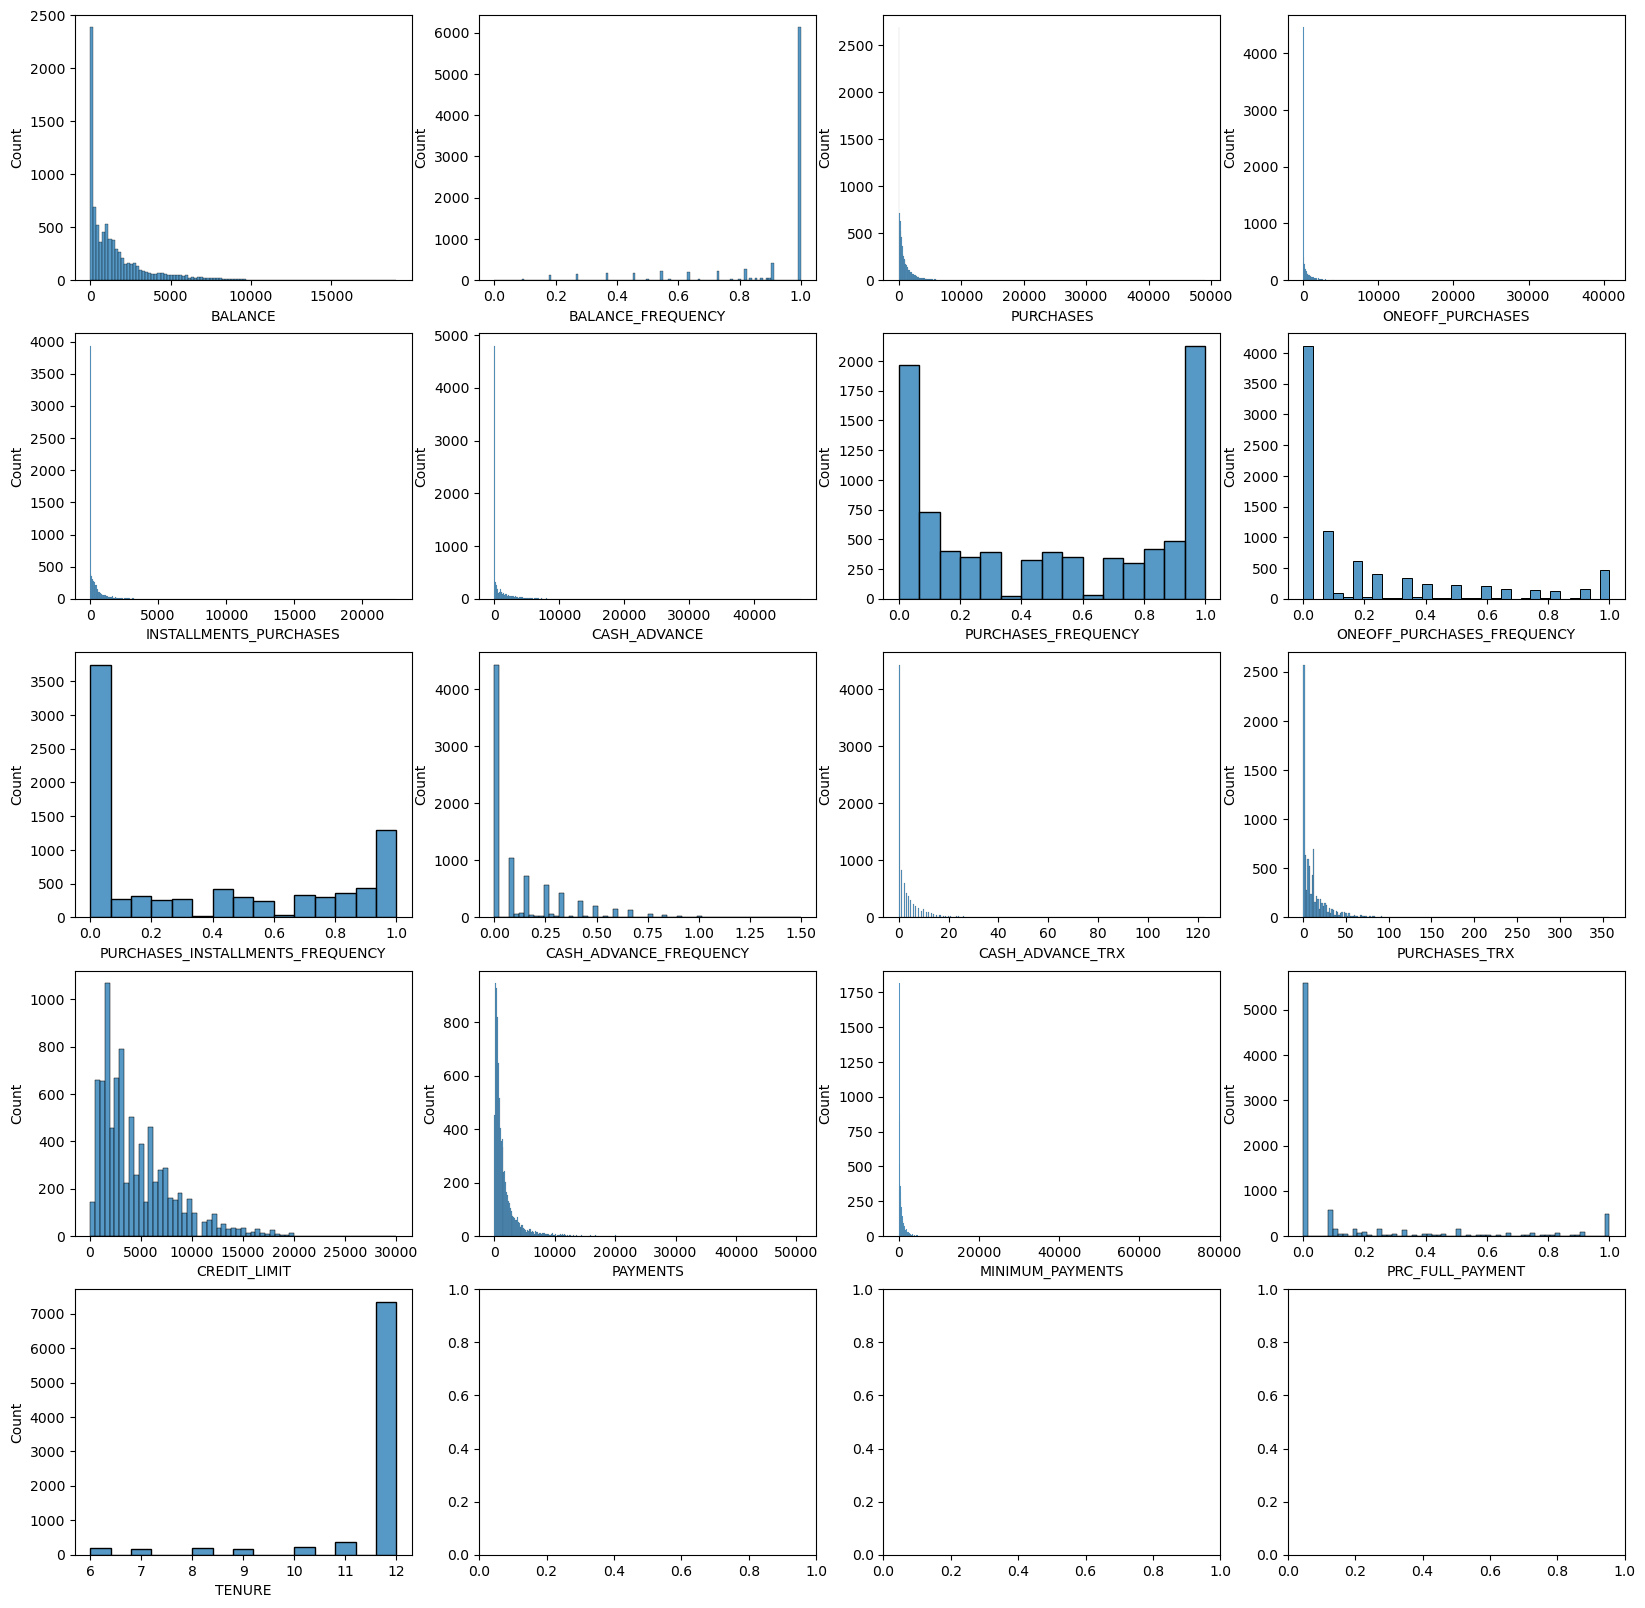

In [37]:
fig, axes = plt.subplots(nrows= 5, ncols= 4, figsize = (20, 20))
axes = np.ravel(axes)
for i, j in enumerate(credit_card1.columns):
  sns.histplot(ax= axes[i], data = credit_card1, x = j)

## Normalize the data

In [38]:
std = StandardScaler()
credit_card1.iloc[:,:]= std.fit_transform(credit_card1.iloc[:,:])

## PCA to deduce dimension of feature

In [39]:
# reduce feasture to 4 dimension
pca = PCA(n_components= 4, )
credit_card2 = pca.fit_transform(credit_card1)
pca.explained_variance_ratio_.sum()

0.6409742688919324

### Function 

In [40]:
# sihouette plot function
def silhouette_plot(data, predict_label):
  # original y_lower and y_upper 
  si_core = silhouette_score(X = data, labels= predict_label)
  y_upper , y_lower = 0, 0 
  si_sample = silhouette_samples(X = data, labels= predict_label)
  ytick_list = ['Cluster ' + str(i) for i in np.unique(predict_label)]
  y_middle = []
  for i in np.unique(predict_label):
    cond = predict_label == i
    si_sample_i = np.sort(si_sample[cond])
    y_upper = y_upper + len(si_sample_i)
    y_middle.append((y_upper + y_lower)/2) 
    plt.barh(y = range(y_lower, y_upper), width = si_sample_i, height = 1)
    y_lower = y_lower + len(si_sample_i)
  plt.axvline(x = si_core, linestyle = '--', c = 'r')
  plt.text(x = si_core, y = -10, s = 'sci_core = %s' %(si_core.round(2)))
  plt.yticks(ticks = y_middle, labels= ytick_list )
  plt.show()

In [66]:
# function of plot cluster 

def cluster_plot(data, predict_label):
  n = len(np.unique(predict_label))
  palette_list = ['red', 'green', 'blue', 'purple','black', 'pink', 'yellow']
  fig, axes = plt.subplots(figsize = (9,8))
  sns.scatterplot(x = data[:,0], y = data[:, 1], hue = predict_label, palette = palette_list[0: n] )

## Cluster

### Kmean++ 

In [48]:
# number of cluster 
nu_cluster = 3

In [49]:
kmean = KMeans(n_clusters = nu_cluster, init = 'k-means++', n_init= 10, max_iter= 300, tol = 0.0001)
kmean.fit(credit_card2)
# predict the cluster
predict_cluster = kmean.labels_
# centroid
centroid = kmean.cluster_centers_

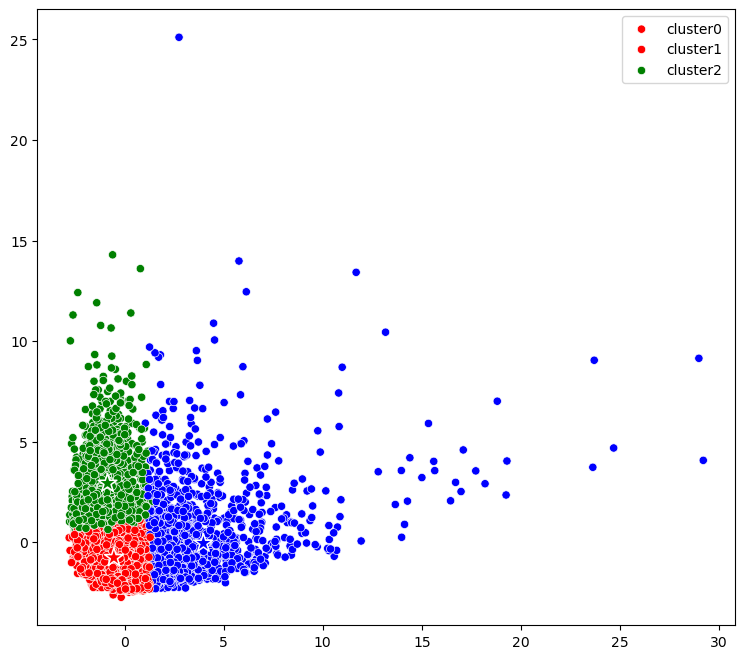

In [69]:
# plot cluster
# legend list
legend_list = ['cluster' + str(i) for i in np.unique(predict_cluster)]
# palette list 
palette_list = palette_list = ['red', 'green', 'blue', 'purple','black', 'pink', 'yellow']
# cluster number 
n = len(np.unique(predict_cluster))
# plot clusters
cluster_plot(credit_card2, predict_cluster)
# plot centroid
sns.scatterplot(x = centroid[:,0], y = centroid[:, 1], marker = '*',s = 200, hue = np.unique(predict_cluster), palette= palette_list[0: n] )
plt.legend(legend_list)
plt.show()

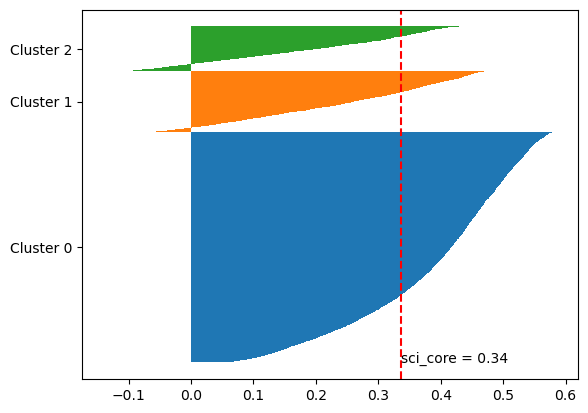

In [51]:
# plot silhouette plot
silhouette_plot(credit_card2, predict_cluster)

### Bisecting kmeans

In [71]:
bkmeans = BisectingKMeans(n_clusters = nu_cluster, init= 'k-means++', )
predict_cluster = bkmeans.fit_predict(credit_card2)

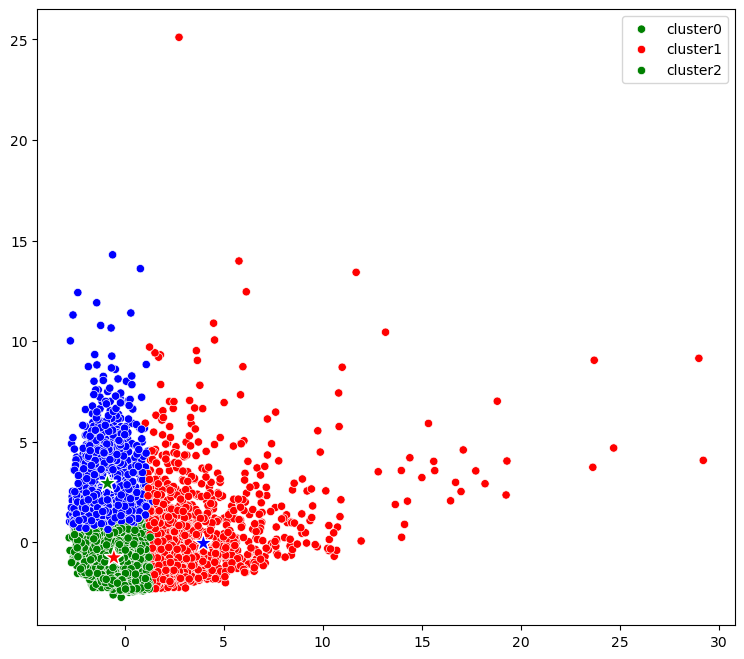

In [72]:
# plot cluster
# legend list
legend_list = ['cluster' + str(i) for i in np.unique(predict_cluster)]
m = len(np.unique(predict_cluster))
# plot clusters
cluster_plot(credit_card2, predict_cluster)
# plot centroid
sns.scatterplot(x = centroid[:,0], y = centroid[:, 1], marker = '*',s = 200, hue = np.unique(predict_cluster), palette= palette_list[0: m])
plt.legend(legend_list)
plt.show()

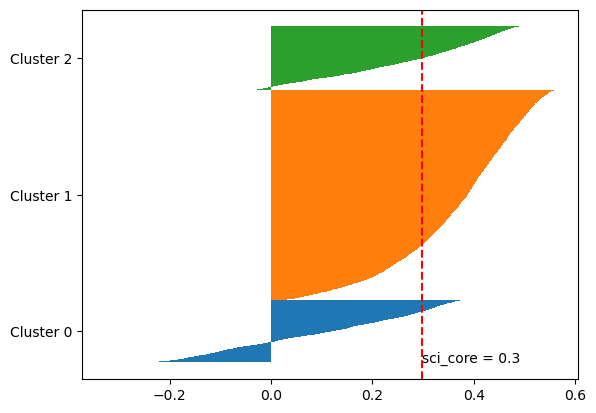

In [73]:
silhouette_plot(data = credit_card2, predict_label= predict_cluster)

### Hierarchical 

In [74]:
# use hierarchical 'ward' to cluster 
row_cluster = linkage(credit_card2, method = 'ward', metric = 'euclidean')

# set a threshold to cut the dendrogram 
threshold = row_cluster[:, 2].max() * 0.5 

Text(0, 98.47322859803057, 'threshold = 98.47')

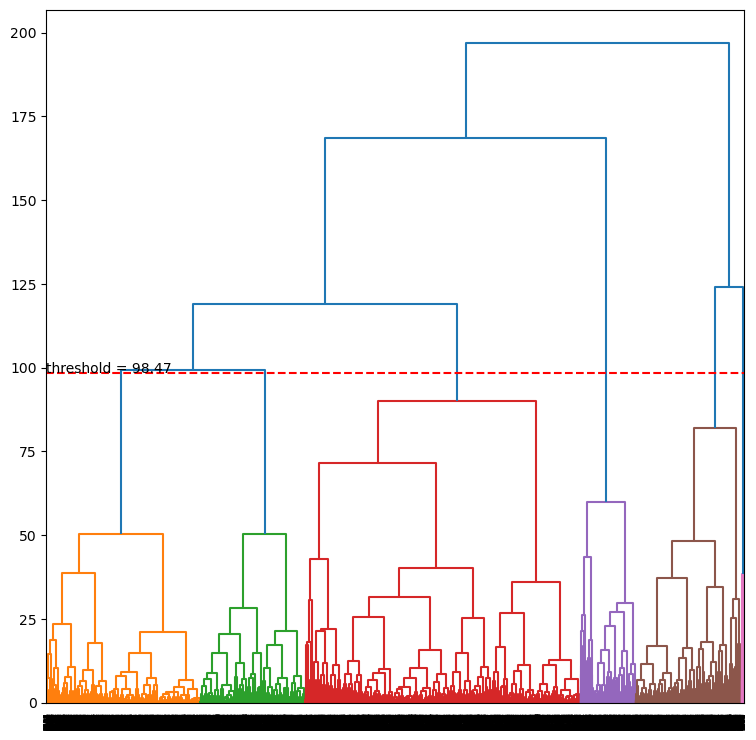

In [77]:
# use dendrogram to show clusters
fig, axes = plt.subplots(figsize = (9,9))
den = dendrogram(row_cluster, color_threshold= threshold, distance_sort = 'descending')
plt.axhline(y = threshold, linestyle = '--', c = 'red')
plt.text(x = 0, y = threshold, s = 'threshold = %s' %(threshold.round(2)))
plt.show()

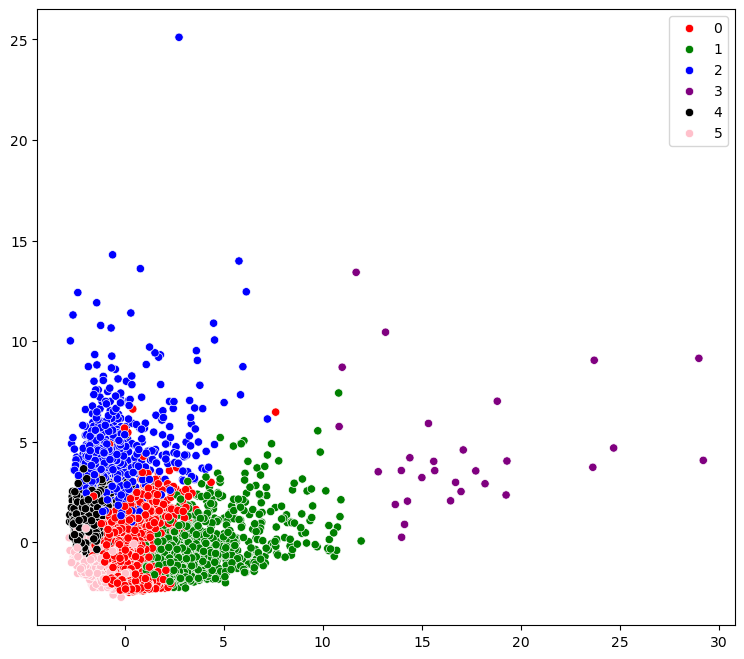

In [87]:
# the number of color which bellow the threshold line
nu_cluster = len(np.unique(den['color_list']))-1
nu_cluster
# plot the clusters
ag = AgglomerativeClustering(n_clusters= nu_cluster, linkage = 'ward')
# fit the cluster model 
predict_cluster = ag.fit_predict(X = credit_card2)
# plot the cluster 
cluster_plot(credit_card2, predict_cluster)

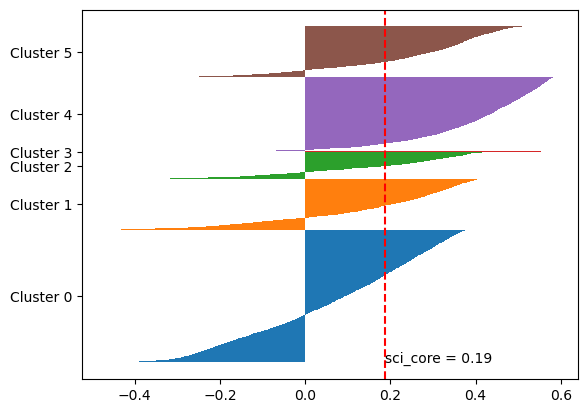

In [88]:
# plot the silhouette 
silhouette_plot(data = credit_card2, predict_label= predict_cluster)

### DBSCAN 

In [100]:
min_sample = 8
# silhouette core for each eps 
silhouettecore = []
for i in np.arange(0.5, 10, 0.5):
  dbscan = DBSCAN(eps = i, min_samples = min_sample)
  predict_cluster = dbscan.fit_predict(X = credit_card2)
  silhouettecore.append(silhouette_score(X = credit_card2, labels= predict_cluster))
print(silhouettecore)

[-0.2564236109872441, 0.5557394107663505, 0.6219945474815901, 0.7198051572229968, 0.7640190517802212, 0.7816957236709303, 0.7910455027902001, 0.7906561039082256, 0.823681632013578, 0.8284017842239411, 0.8384270626296507, 0.8384270626296507, 0.8484716405525274, 0.8618115514082579, 0.8711210259902876, 0.8726738665556935, 0.8726738665556935, 0.8568069529628919, 0.8568069529628919]


In [108]:
# max of silhouette core
max_i = max(silhouettecore)
# find the eps which has the maximum silhouette score
arg_max = np.where(silhouettecore == max_i)[0]
max_eps = ( arg_max -1 ) * 0.5
max_eps 


array([7. , 7.5])

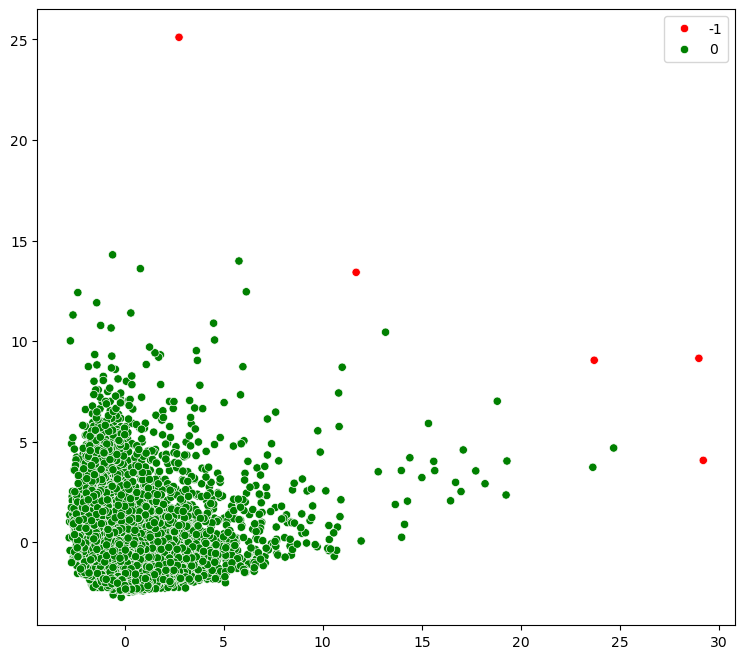

In [110]:
# dbscan with eps = 7 and min_samples = 8
dbscan = DBSCAN(eps = 7, min_samples = 8)
predict_cluster = dbscan.fit_predict(credit_card2)
# plot the clusters
cluster_plot(data = credit_card2, predict_label = predict_cluster)

### HDBSCAN